In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import palantir
import os

# Data preprocessing

In [3]:
#functions
def preprocess_time_series_data(
    adata, time_col="development_stage", celltype_col="cell_type"
):
    """
    Comprehensive preprocessing pipeline for time series single-cell data with multiple cell types.

    Parameters:
    - time_col: column name for time points/development stages
    - celltype_col: column name for cell types
    """

    print("Starting preprocessing pipeline...")
    print(f"Data shape: {adata.shape}")

    # 1. Quality Control
    print("\n1. Quality Control...")

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=[], percent_top=None, log1p=False, inplace=True
    )

    # Filter cells: minimum genes, maximum mitochondrial percentage
    sc.pp.filter_cells(adata, min_genes=200)
    adata = adata[adata.obs.n_genes_by_counts < 5000]  # Remove potential doublets

    # Filter genes: minimum cells
    sc.pp.filter_genes(adata, min_cells=10)

    print(f"After QC: {adata.shape}")

    # 2. Normalization and Log Transformation
    print("\n2. Normalization...")
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 counts per cell
    sc.pp.log1p(adata)  # Log transform

    # 3. Feature Selection
    print("\n3. Feature Selection...")
    sc.pp.highly_variable_genes(
        adata, n_top_genes=3000, subset=False, flavor="seurat_v3"
    )

    # highly variable genes
    adata = adata[:, adata.var.highly_variable]
    print(f"After HVG selection: {adata.shape}")

    # 4. Scale the data
    print("\n4. Scaling...")
    sc.pp.scale(adata, max_value=10)  # Scale to max value of 10

    # 5. Dimensionality Reduction
    print("\n5. PCA...")
    sc.tl.pca(adata, n_comps=50, svd_solver="arpack")

    # 6. Use Raw PCA (No Batch Correction)
    print("\n6. Using raw PCA (no batch correction)")
    use_rep = "X_pca"

    # 7. Neighborhood Graph and Clustering
    print("\n7. Computing Neighborhood Graph...")
    sc.pp.neighbors(adata, n_neighbors=30, use_rep=use_rep)

    print("Computing UMAP...")
    sc.tl.umap(adata)

    print("Clustering...")
    sc.tl.leiden(adata, resolution=1.0)

    # 8. Optional: Cell Type Annotation (if not already present)
    if celltype_col not in adata.obs.columns or adata.obs[celltype_col].isna().any():
        print("\n8. Cell Type Annotation needed...")
        print(
            "Consider using marker genes or reference datasets for cell type annotation"
        )

    # 9. Setup for Trajectory Analysis
    print("\n9. Preparing for Trajectory Analysis...")

    # Add time point ordering for trajectory analysis
    if time_col in adata.obs.columns:
        # Create numerical time ordering if time points are categorical
        time_stages = adata.obs[time_col].unique()
        time_order = {stage: i for i, stage in enumerate(sorted(time_stages))}
        adata.obs["time_order"] = adata.obs[time_col].map(time_order)
        print(f"Time stages found: {time_stages}")

    print("Preprocessing completed!")
    print(f"Final data shape: {adata.shape}")
    print(f"Variables in obs: {list(adata.obs.columns)}")

    return adata

def visualize_preprocessing(adata, time_col='development_stage', celltype_col='cell_type'):
    """Create diagnostic plots for preprocessed data"""
    
    # Set up plotting
    import matplotlib.pyplot as plt
    sc.set_figure_params(dpi=100, figsize=(6, 6))
    
    # UMAP colored by time points
    if time_col in adata.obs.columns:
        sc.pl.umap(adata, color=time_col, title="UMAP by Time Points")
    
    # UMAP colored by cell types (if available)
    if celltype_col in adata.obs.columns:
        sc.pl.umap(adata, color=celltype_col, title="UMAP by Cell Types")
    
    # UMAP colored by clusters
    sc.pl.umap(adata, color='leiden', title="UMAP by Clusters")
    
    # QC metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(adata.obs['n_genes_by_counts'], bins=50)
    axes[0].set_title('Number of Genes per Cell')
    axes[0].set_xlabel('Genes')
    axes[0].set_ylabel('Cells')
    
    axes[1].hist(adata.obs['total_counts'], bins=50)
    axes[1].set_title('Total Counts per Cell')
    axes[1].set_xlabel('Total Counts')
    
    axes[2].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], alpha=0.5, s=1)
    axes[2].set_title('Counts vs Genes')
    axes[2].set_xlabel('Total Counts')
    axes[2].set_ylabel('Number of Genes')
    
    plt.tight_layout()
#    plt.savefig('plots/qc_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

In [5]:
#read data
adata = sc.read_h5ad('data/GSE104323_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 24185 × 27933
    obs: 'source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode'

In [6]:
#check counts
adata.X.sum(axis=1)

matrix([[5888],
        [1567],
        [2115],
        ...,
        [4045],
        [4665],
        [3200]], shape=(24185, 1))

raw counts

In [7]:
#extract subset of pyramidal cells
subset = adata[adata.obs['characteristics: cell cluster']=='Immature-Pyr']
subset = subset[subset.obs['characteristics: age'].isin(['E16.5', 'P0', 'P5', 'P23'])]
subset

View of AnnData object with n_obs × n_vars = 4518 × 27933
    obs: 'source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode'

In [8]:
#filter data
adata_result = preprocess_time_series_data(subset, "characteristics: age", "characteristics: cell cluster")

Starting preprocessing pipeline...
Data shape: (4518, 27933)

1. Quality Control...


/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After QC: (4496, 14265)

2. Normalization...

3. Feature Selection...


/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


After HVG selection: (4496, 3000)

4. Scaling...


/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)



5. PCA...

6. Using raw PCA (no batch correction)

7. Computing Neighborhood Graph...


/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing UMAP...
Clustering...


/tmp/ipykernel_1457203/3343003484.py:68: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)



9. Preparing for Trajectory Analysis...
Time stages found: ['E16.5', 'P0', 'P5', 'P23']
Categories (4, object): ['E16.5', 'P0', 'P5', 'P23']
Preprocessing completed!
Final data shape: (4496, 3000)
Variables in obs: ['source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'time_order']


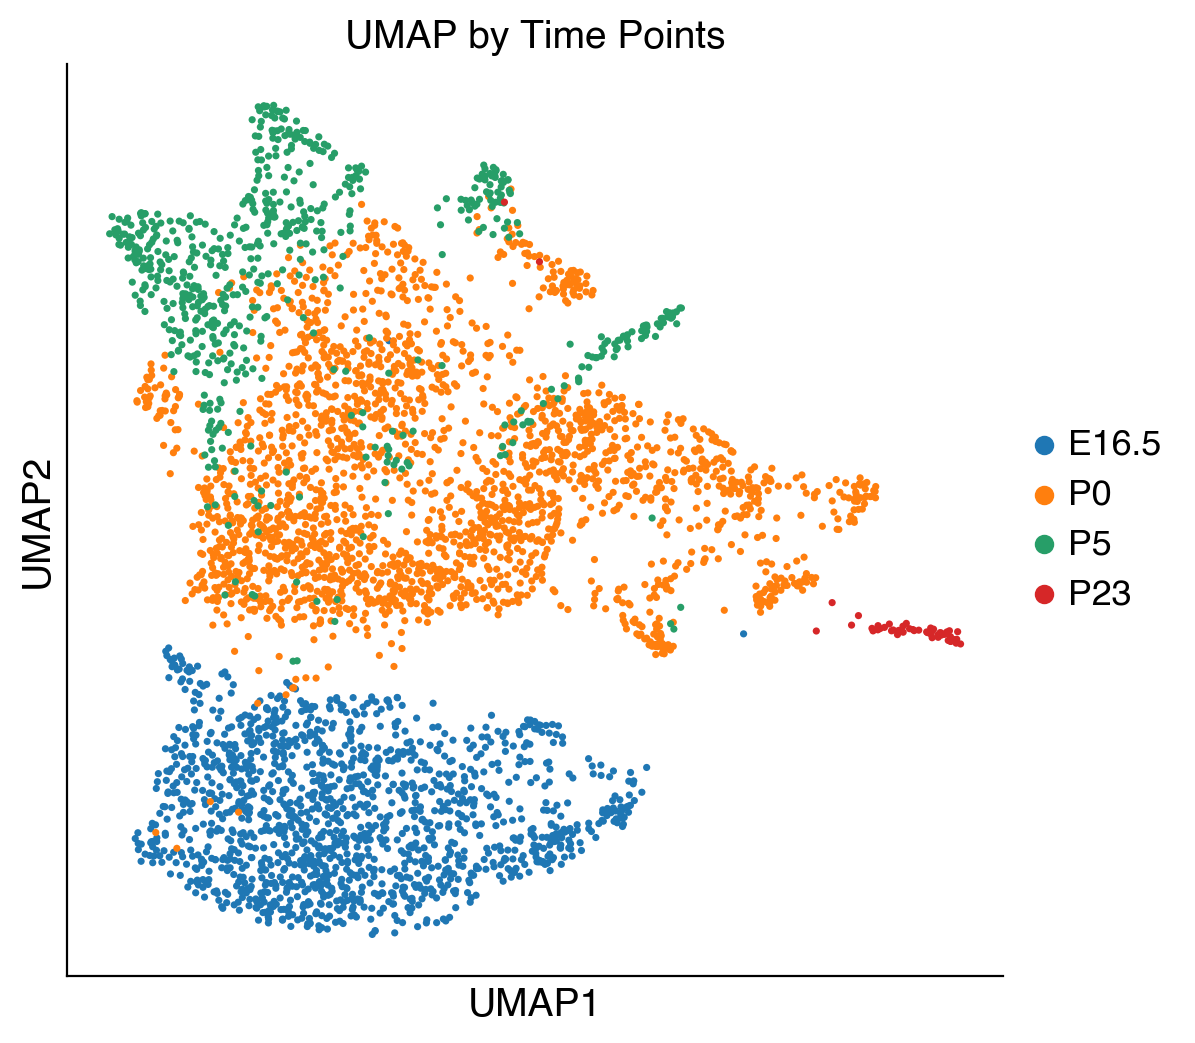

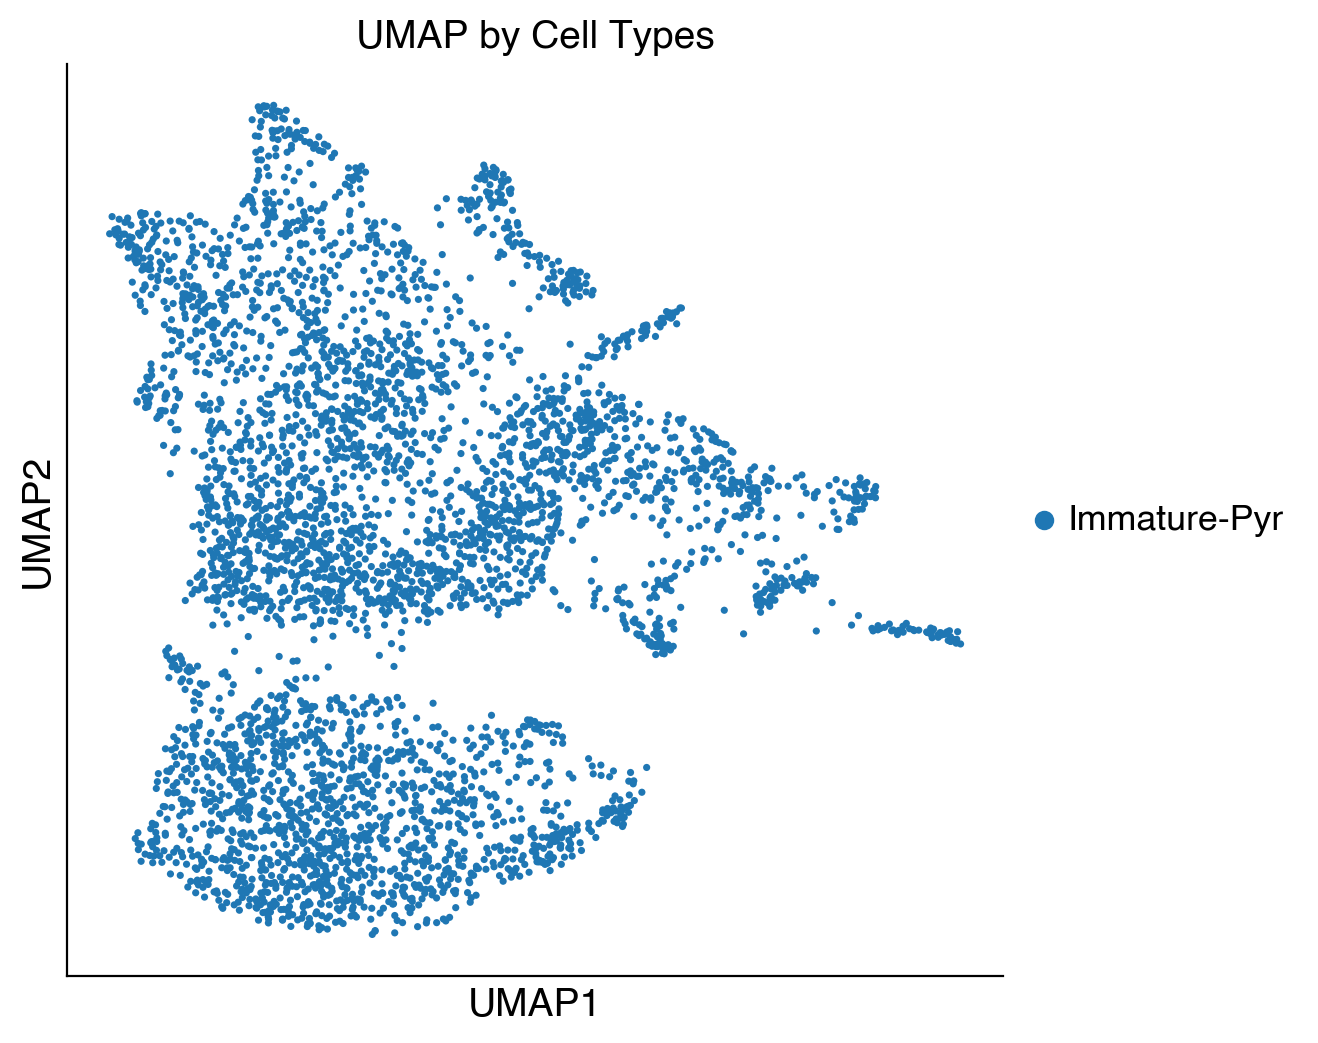

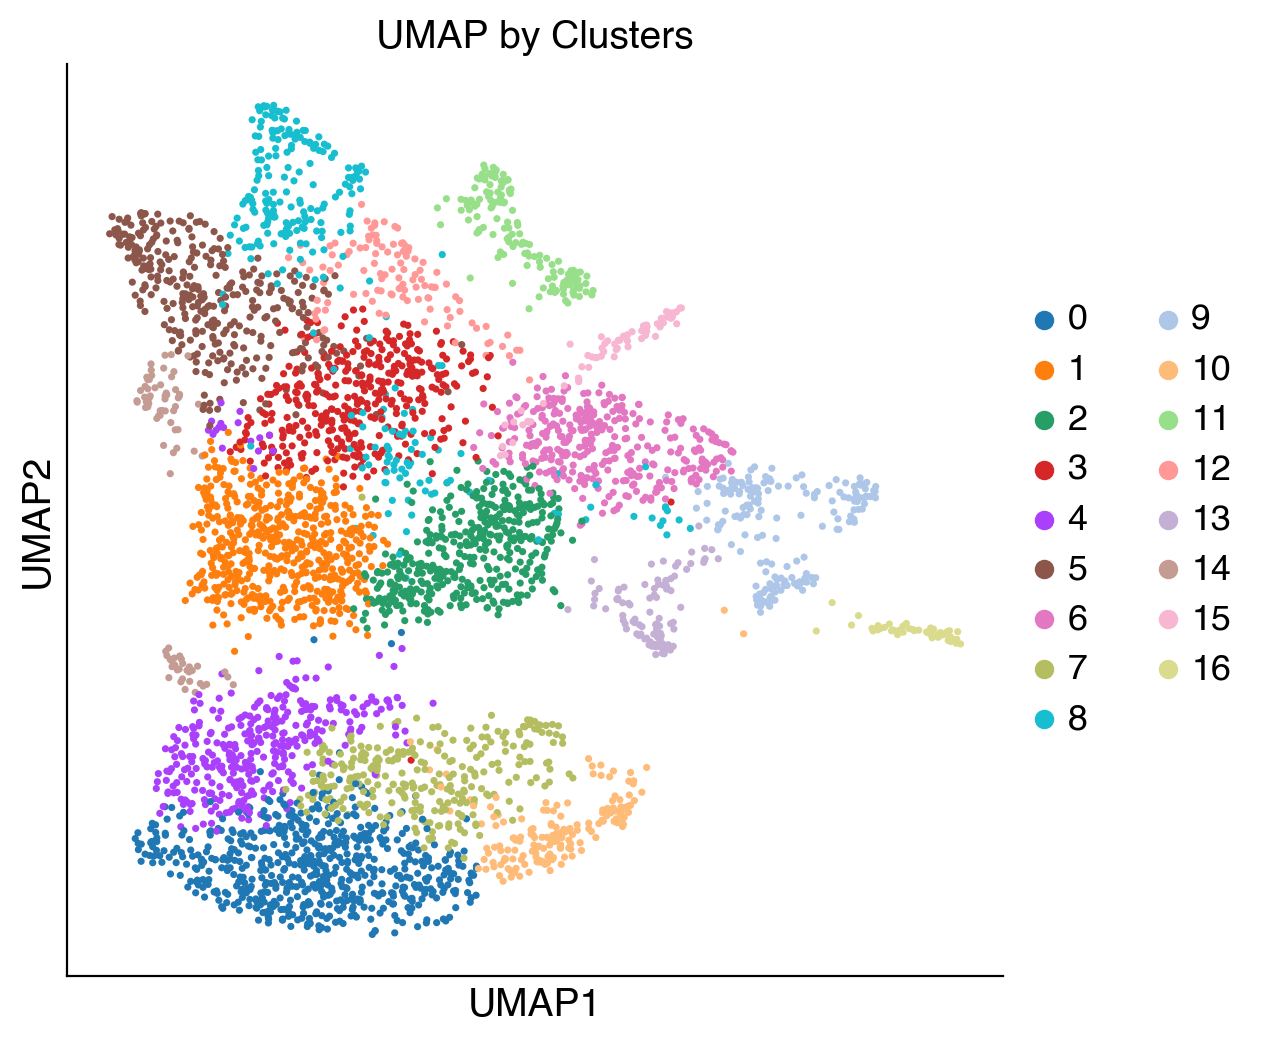

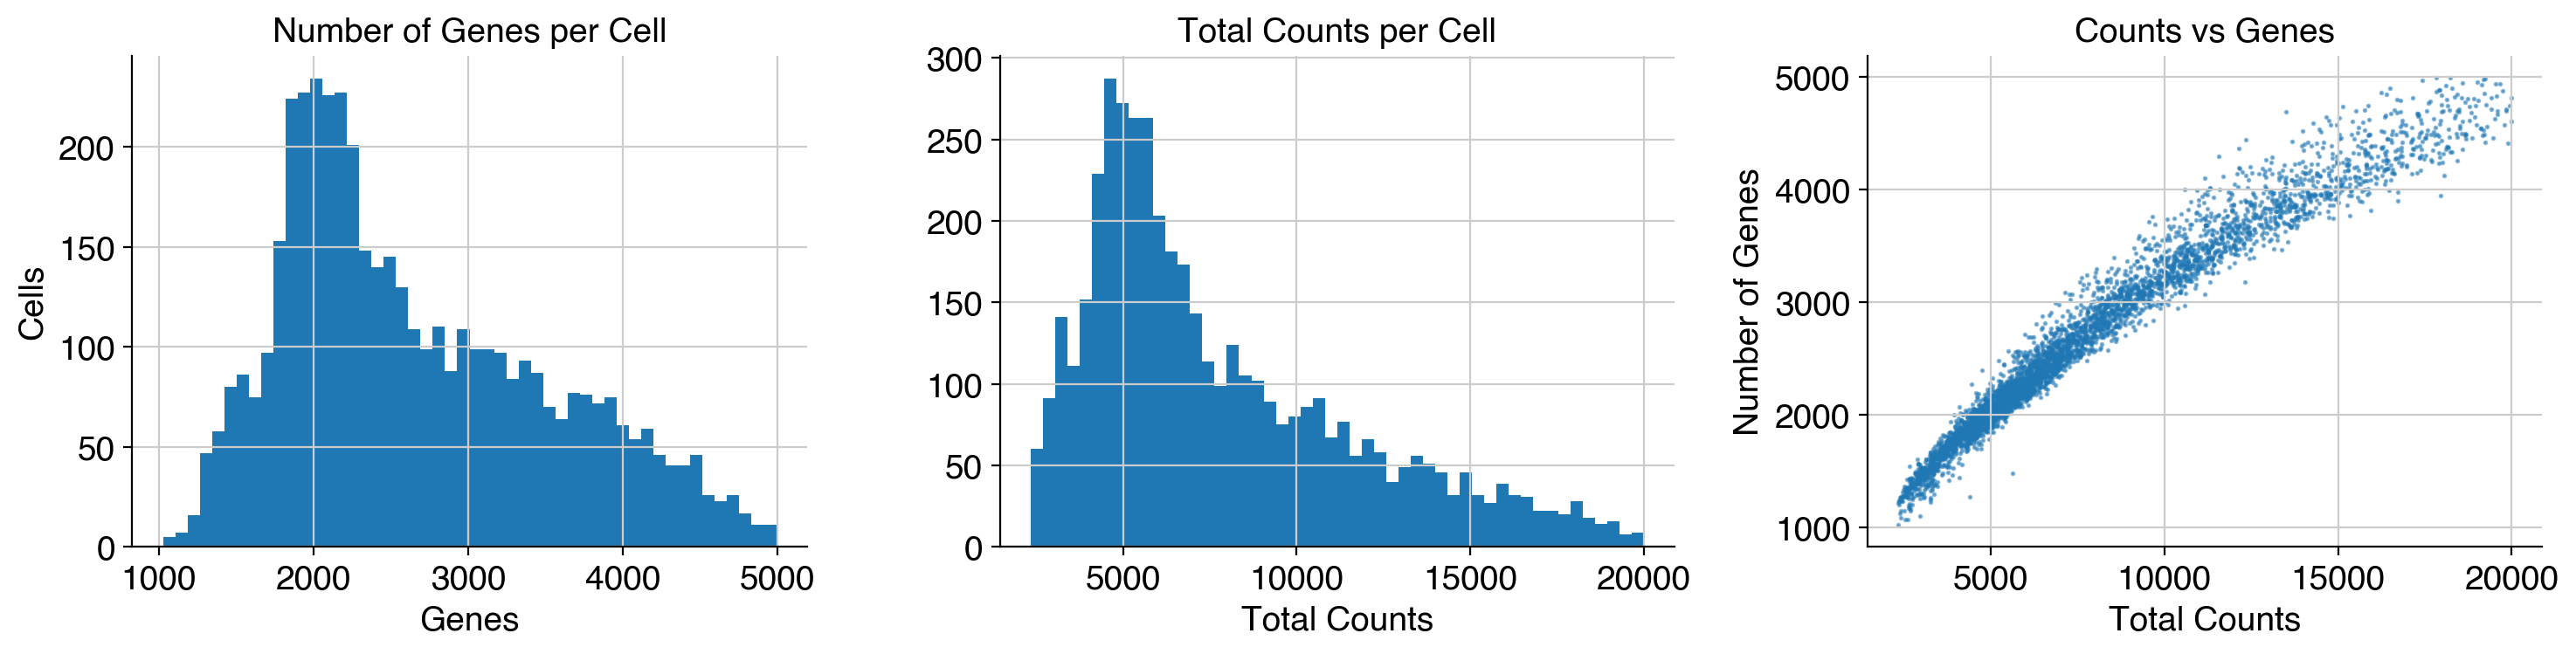

In [9]:
#vizualize
visualize_preprocessing(adata_result, "characteristics: age", "characteristics: cell cluster")

In [10]:
#save preprocessed adata
adata_result.write_h5ad('GSE104323_filtered_imm_pyr_cellrank_env.h5ad')

In [4]:
#load preprocessed data
adata_result = sc.read_h5ad('GSE104323_filtered_imm_pyr_cellrank_env.h5ad')
adata_result

AnnData object with n_obs × n_vars = 4496 × 3000
    obs: 'source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'time_order'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'characteristics: age_colors', 'characteristics: cell cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Select early cells

random selection of 3 cells from E16.5 age group

In [5]:
subset_young = adata_result[adata_result.obs['characteristics: age'] == 'E16.5']

In [6]:
subset_young.obs.sample(3, random_state=1)

,source name,organism,characteristics: strain,characteristics: age,characteristics: sex of pooled animals,characteristics: cell cluster,molecule,SRR run accession,raw file (original file name),UMI_CellularBarcode,n_genes_by_counts,total_counts,n_genes,leiden,time_order
Sample name (24185 single cells),,,,,,,,,,,,,,,
10X82_1_TGGTAGTGTGACGA-,dentate gyrus,Mus musculus,CD-1,E16.5,unknown,Immature-Pyr,total RNA,SRR6083576,10X82_1_TGGTAGTGTGACGA.fq.gz,ATGAAAGAAA_TGGTAGTGTGACGA,2166,5938,2166,7,0
10X82_1_TGGACTCCTCCTAG-,dentate gyrus,Mus musculus,CD-1,E16.5,unknown,Immature-Pyr,total RNA,SRR6083555,10X82_1_TGGACTCCTCCTAG.fq.gz,AGTAAAGAGT_TGGACTCCTCCTAG,3397,10595,3397,7,0
10X82_1_GTCTGAGATCGATA-,dentate gyrus,Mus musculus,CD-1,E16.5,unknown,Immature-Pyr,total RNA,SRR6083486,10X82_1_GTCTGAGATCGATA.fq.gz,GGAACGGCAC_GTCTGAGATCGATA,2140,5761,2140,0,0


In [7]:
selected_cells = subset_young.obs.sample(3, random_state=1).index.to_list()
selected_cells

['10X82_1_TGGTAGTGTGACGA-',
 '10X82_1_TGGACTCCTCCTAG-',
 '10X82_1_GTCTGAGATCGATA-']

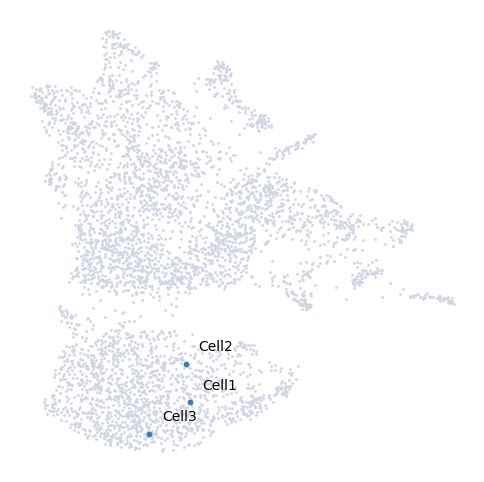

In [8]:
#plot selected early cells
early_cells = pd.Series(['Cell1', 'Cell2', 'Cell3'], index=selected_cells)
palantir.plot.highlight_cells_on_umap(adata_result, early_cells)
plt.show()

# Palantir

/home/v_sagitova/.conda/envs/cellrank/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


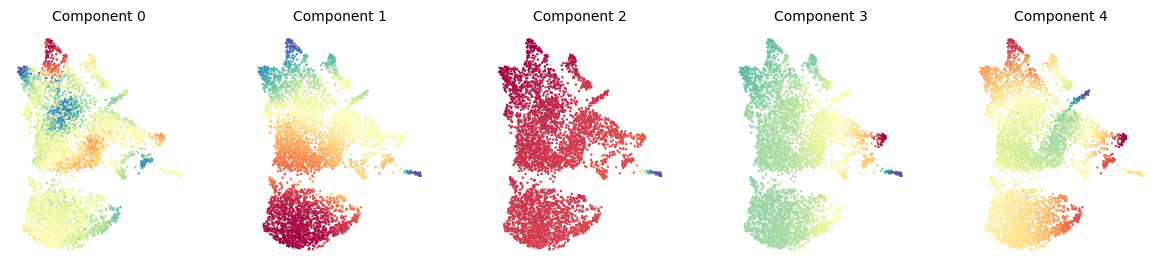

In [9]:
# 1.Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata_result, n_components=5, pca_key='X_pca')
ms_data = palantir.utils.determine_multiscale_space(adata_result)
#plot diffusion components
palantir.plot.plot_diffusion_components(adata_result)
plt.show()



In [10]:
#early cells
early_cells

10X82_1_TGGTAGTGTGACGA-    Cell1
10X82_1_TGGACTCCTCCTAG-    Cell2
10X82_1_GTCTGAGATCGATA-    Cell3
dtype: object

Sampling and flocking waypoints...
Time for determining waypoints: 0.006367941697438558 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.13381951649983723 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


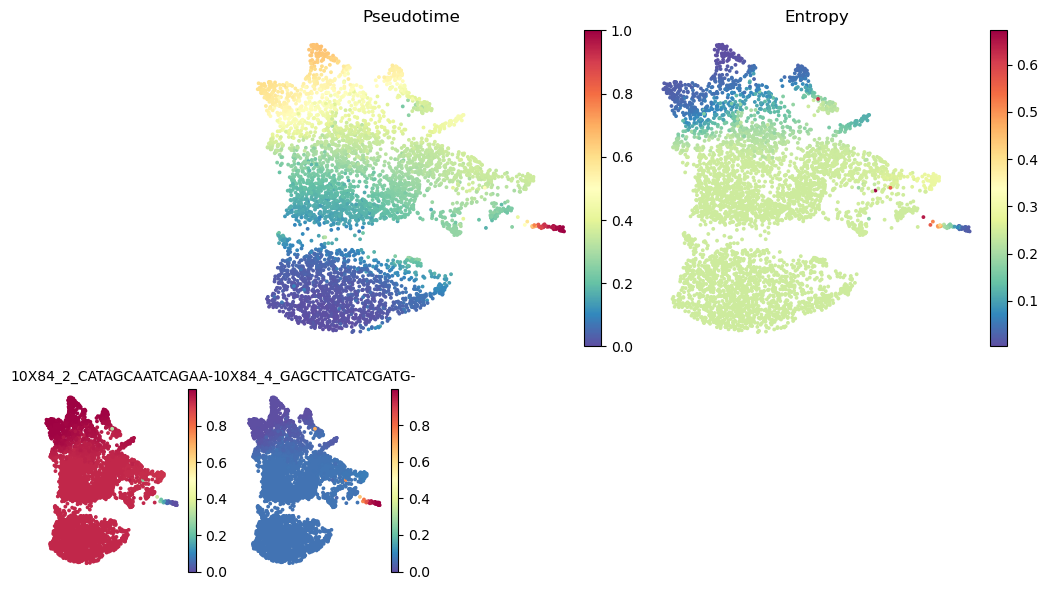

In [11]:
# 2.Run palantir algorithm with early cell 1
start_cell = early_cells.index[0]
adata_cell1 = adata_result.copy()
pr_res_1 = palantir.core.run_palantir(
    adata_cell1, start_cell, num_waypoints=500)
#plot results 
palantir.plot.plot_palantir_results(adata_cell1, s=3)
plt.show()

In [13]:
#terminal states (same that are given in palantir.core.run_palantir with the same early cell)
terminal = palantir.core.identify_terminal_states(ms_data, start_cell)
terminal

Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.07734266916910808 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Markov chain construction...
Identification of terminal states...


(array(['10X84_2_CATAGCAATCAGAA-'], dtype='<U23'),
 Index(['10X84_4_GAGCTTCATCGATG-'], dtype='object'))

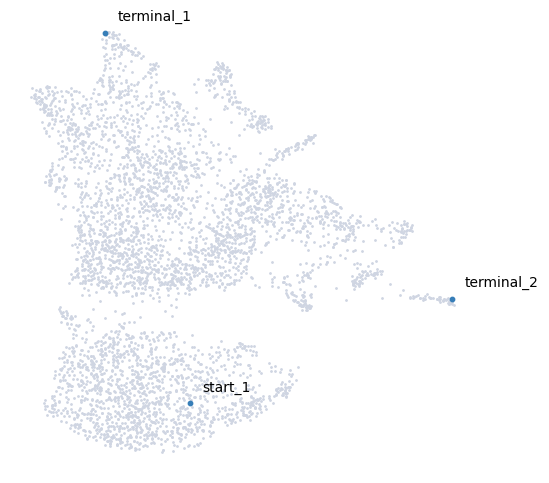

In [14]:
#early and terminal states
cells_to_plot = pd.Series(['terminal_1', 'terminal_2', 'start_1'], index=['10X84_2_CATAGCAATCAGAA-', 
                                                                          '10X84_4_GAGCTTCATCGATG-', 
                                                                          '10X82_1_TGGTAGTGTGACGA-'])
palantir.plot.highlight_cells_on_umap(adata_cell1, cells_to_plot)
plt.show()

Sampling and flocking waypoints...
Time for determining waypoints: 0.005852003892262776 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.042403705914815265 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.08020583391189576 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Markov chain construction...
Identification of terminal states...


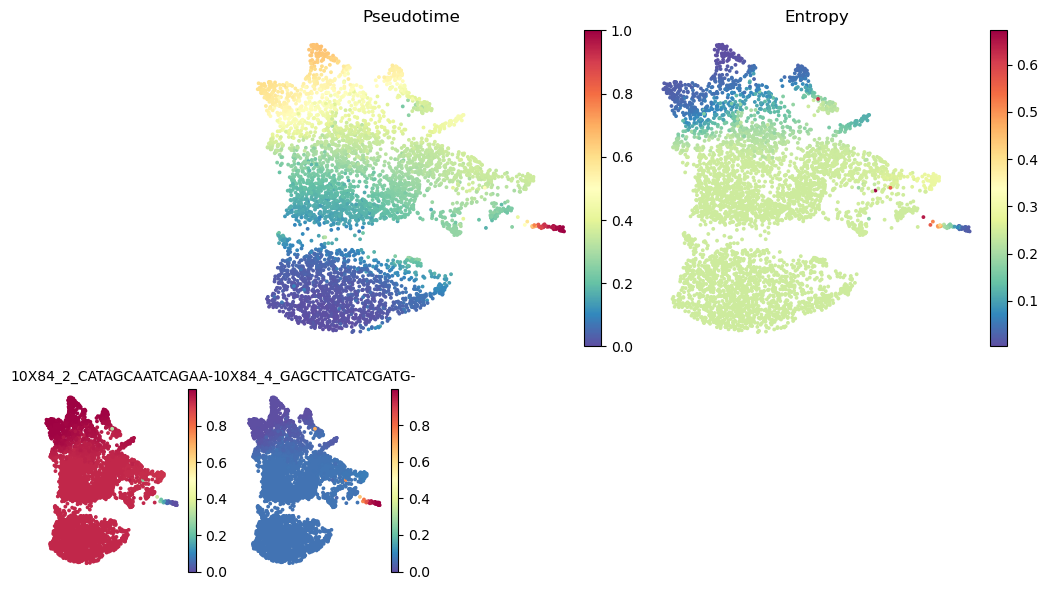

In [15]:
# 2.Run palantir algorithm with early cell 2
start_cell = early_cells.index[1]
adata_cell2 = adata_result.copy()
pr_res_2 = palantir.core.run_palantir(
    adata_cell2, start_cell, num_waypoints=500)
#get terminal states
terminal = palantir.core.identify_terminal_states(ms_data, start_cell)
#plot results 
palantir.plot.plot_palantir_results(adata_cell2, s=3)
plt.show()

In [16]:
#terminal states
terminal

(array(['10X84_2_CATAGCAATCAGAA-'], dtype='<U23'),
 Index(['10X84_4_GAGCTTCATCGATG-'], dtype='object'))

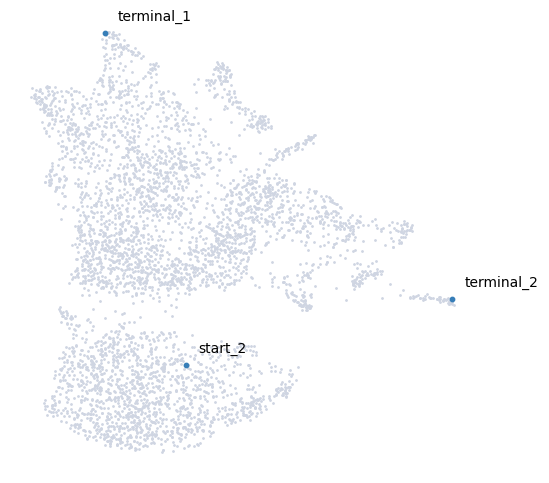

In [17]:
#early and terminal states
cells_to_plot = pd.Series(['terminal_1', 'terminal_2', 'start_2'], index=['10X84_2_CATAGCAATCAGAA-', 
                                                                          '10X84_4_GAGCTTCATCGATG-', 
                                                                          '10X82_1_TGGACTCCTCCTAG-'])
palantir.plot.highlight_cells_on_umap(adata_cell2, cells_to_plot)
plt.show()

Sampling and flocking waypoints...
Time for determining waypoints: 0.006993818283081055 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.04443455139795939 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.08304932912190756 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Markov chain construction...
Identification of terminal states...


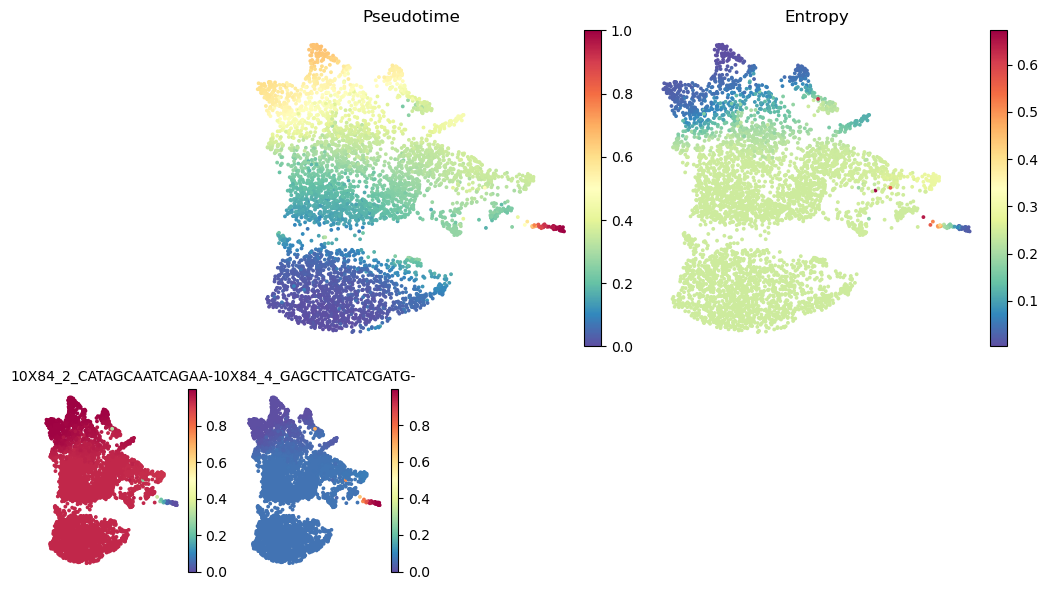

In [18]:
# 2.Run palantir algorithm with early cell 3
start_cell = early_cells.index[2]
adata_cell3 = adata_result.copy()
pr_res_3 = palantir.core.run_palantir(
    adata_cell3, start_cell, num_waypoints=500)
#get terminal states
terminal = palantir.core.identify_terminal_states(ms_data, start_cell)
#plot results 
palantir.plot.plot_palantir_results(adata_cell3, s=3)
plt.show()

In [19]:
terminal

(array(['10X84_2_CATAGCAATCAGAA-'], dtype='<U23'),
 Index(['10X84_4_GAGCTTCATCGATG-'], dtype='object'))

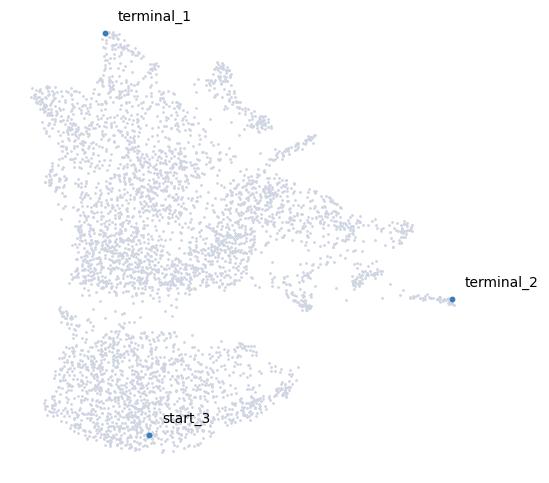

In [21]:
#early and terminal states
cells_to_plot = pd.Series(['terminal_1', 'terminal_2', 'start_3'], index=['10X84_2_CATAGCAATCAGAA-', 
                                                                          '10X84_4_GAGCTTCATCGATG-', 
                                                                          '10X82_1_GTCTGAGATCGATA-'])
palantir.plot.highlight_cells_on_umap(adata_cell3, cells_to_plot)
plt.show()

## Plot branch probabilities

Early cell - cell1

In [22]:
#choose random cell from P5
P5_subset = adata_cell1[adata_cell1.obs['characteristics: age'] == 'P5', :]
P5_cell = P5_subset.obs.sample(1, random_state=1)
P5_cell

,source name,organism,characteristics: strain,characteristics: age,characteristics: sex of pooled animals,characteristics: cell cluster,molecule,SRR run accession,raw file (original file name),UMI_CellularBarcode,n_genes_by_counts,total_counts,n_genes,leiden,time_order,palantir_pseudotime,palantir_entropy
Sample name (24185 single cells),,,,,,,,,,,,,,,,,
10X84_3_CTAATTCGGATGGA-,dentate gyrus,Mus musculus,CD-1,P5,unknown,Immature-Pyr,total RNA,SRR6104679,10X84_3_CTAATTCGGATGGA.fq.gz,TCAACATATC_CTAATTCGGATGGA,4069,14399,4069,3,3,0.391764,0.185344


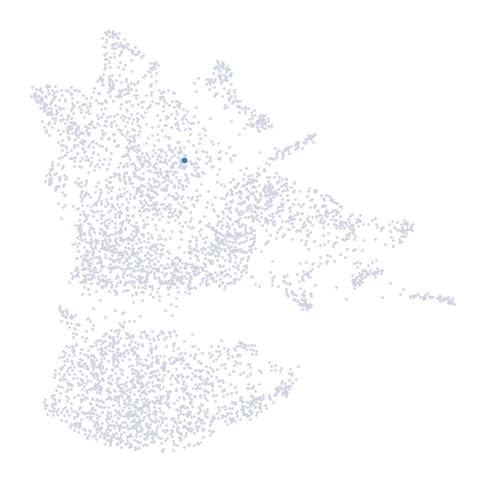

In [23]:
#plot this cell
palantir.plot.highlight_cells_on_umap(adata_cell1, P5_cell.index)
plt.show()

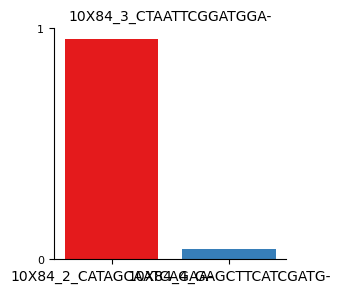

In [24]:
#plot branch probabilities
palantir.plot.plot_terminal_state_probs(adata_cell1, P5_cell.index)
plt.show()

In [31]:
#choose random cell from P23
P23_subset = adata_cell1[adata_cell1.obs['characteristics: age'] == 'P23', :]
P23_cell = P23_subset.obs.sample(1, random_state=1)
P23_cell

,source name,organism,characteristics: strain,characteristics: age,characteristics: sex of pooled animals,characteristics: cell cluster,molecule,SRR run accession,raw file (original file name),UMI_CellularBarcode,n_genes_by_counts,total_counts,n_genes,leiden,time_order,palantir_pseudotime,palantir_entropy
Sample name (24185 single cells),,,,,,,,,,,,,,,,,
10X84_4_GAGCTTCATCGATG-,dentate gyrus,Mus musculus,CD-1,P23,male,Immature-Pyr,total RNA,SRR6101218,10X84_4_GAGCTTCATCGATG.fq.gz,CATTCTATGA_GAGCTTCATCGATG,3718,9555,3718,16,2,1.0,0.019975


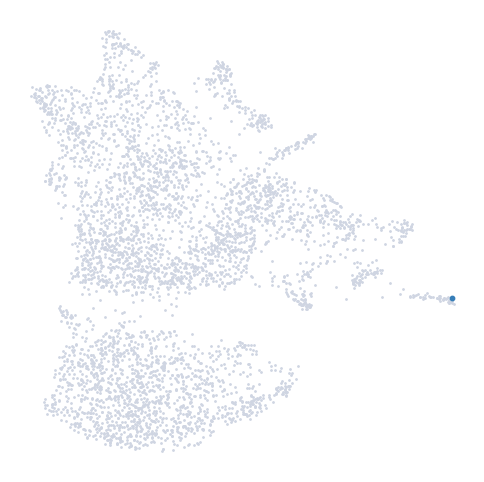

In [32]:
palantir.plot.highlight_cells_on_umap(adata_cell1, P23_cell.index)
plt.show()

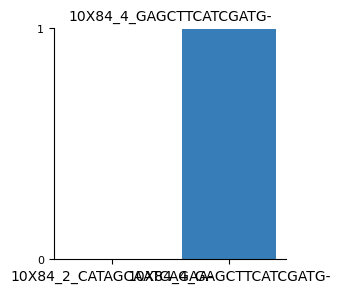

In [33]:
#plot branch probabilities
palantir.plot.plot_terminal_state_probs(adata_cell1, P23_cell.index)
plt.show()

In [34]:
#choose random cell from E16.5
E16_subset = adata_cell1[adata_cell1.obs['characteristics: age'] == 'E16.5', :]
E16_cell = E16_subset.obs.sample(1, random_state=1)
E16_cell

,source name,organism,characteristics: strain,characteristics: age,characteristics: sex of pooled animals,characteristics: cell cluster,molecule,SRR run accession,raw file (original file name),UMI_CellularBarcode,n_genes_by_counts,total_counts,n_genes,leiden,time_order,palantir_pseudotime,palantir_entropy
Sample name (24185 single cells),,,,,,,,,,,,,,,,,
10X82_1_TGGTAGTGTGACGA-,dentate gyrus,Mus musculus,CD-1,E16.5,unknown,Immature-Pyr,total RNA,SRR6083576,10X82_1_TGGTAGTGTGACGA.fq.gz,ATGAAAGAAA_TGGTAGTGTGACGA,2166,5938,2166,7,0,0.015587,0.24347


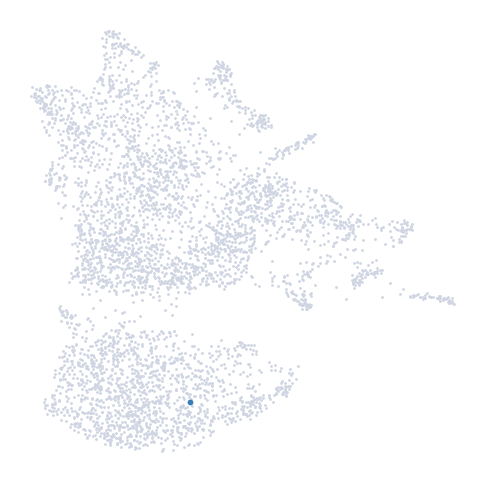

In [36]:
palantir.plot.highlight_cells_on_umap(adata_cell1, E16_cell.index)
plt.show()

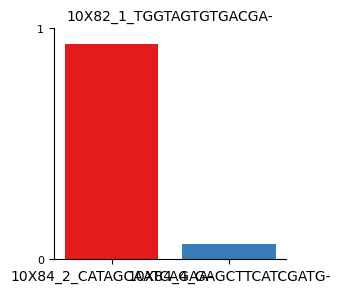

In [37]:
#plot fate probabilities
palantir.plot.plot_terminal_state_probs(adata_cell1, E16_cell.index)
plt.show()

## Trajectories

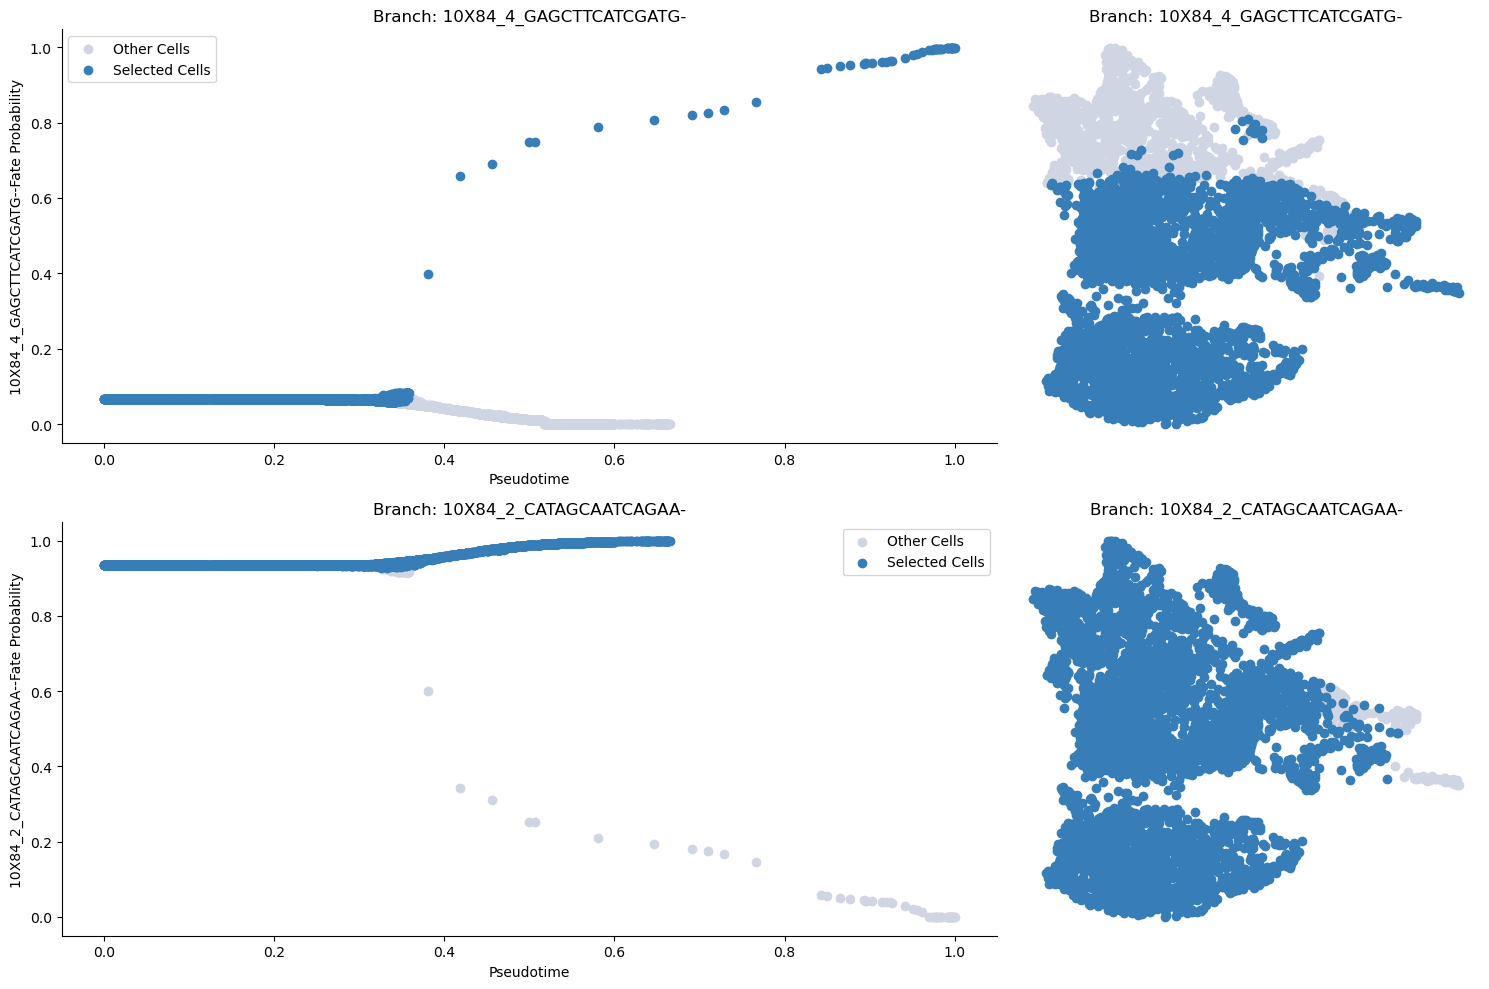

In [38]:
masks = palantir.presults.select_branch_cells(adata_cell1, q=.01, eps=.01)
palantir.plot.plot_branch_selection(adata_cell1)
plt.show()


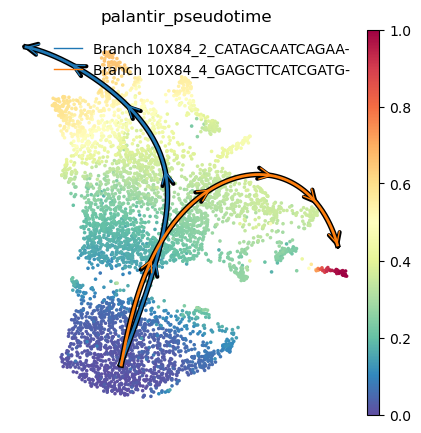

In [39]:
masks = palantir.presults.select_branch_cells(adata_cell1, q=.01, eps=.01)
palantir.plot.plot_trajectories(adata_cell1, pseudotime_interval=(0, .9))
# When using cell_color="branch_selection" be aware of the overlap between branches:
#palantir.plot.plot_trajectories(adata_cell_centr, cell_color = "branch_selection", pseudotime_interval=(0, .9))
plt.show()

